## Self Distillation Notebook

In [1]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("..") # Adds higher directory to python modules path.

import branching

from branching import branches
from branching import evaluate

# branching.enable_neptune(False)


In [2]:
train_ds, test_ds, validation_ds = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 10,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [3]:
train_ds100, test_ds100, validation_ds100 = branching.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


### Define the Branch Model. this is a subclass of the standard Keras model and can do all the normal things

### Load the Datasets
<hr>
validation set is for eval during training, testing set is for eval after training

### make the loss function

In [4]:
K = 10
def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_coef * KL(alp)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C
    return  cross_entropy_evidence

In [5]:
from tensorflow.python.platform import tf_logging as logging
class _earlyStopping(keras.callbacks.EarlyStopping):
    def __init__(self,
               monitor='val_loss',
               min_delta=0,
               patience=0,
               verbose=0,
               mode='auto',
               baseline=None,
               restore_best_weights=False):
        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.baseline = baseline
        self.min_delta = abs(min_delta)
        self.wait = 0
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        # super(_earlyStopping, self).__init__(monitor=)
        if mode not in ['auto', 'min', 'max']:
            logging.warning('EarlyStopping mode %s is unknown, '
                          'fallback to auto mode.', mode)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            
            # if (self.monitor.endswith('acc') or self.monitor.endswith('accuracy') or self.monitor.endswith('auc')):
            self.monitor_op = np.greater
            # else:
                # self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

        self.monitor_op = np.greater
        self.min_delta *= 1
        
    def get_monitor_value(self, logs):
        logs = logs or {}
        monitor_value = 0
        if type(self.monitor) is list:
            for i in self.monitor:
                _log_val = logs.get(i)
                # logging.warning("values are {}, {}".format(i,_log_val))
                if _log_val is None:
                    logging.warning('Metric `%s` '
                          'for early stopping is not available. Available metrics are: %s',
                          i, ','.join(list(logs.keys())))
                else:
                    monitor_value += _log_val
        # monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            logging.warning('Early stopping conditioned on metric `%s` '
                          'which is not available. Available metrics are: %s',
                          self.monitor, ','.join(list(logs.keys())))
        return monitor_value


### define the branch structures

In [ ]:
model_name = "EfficientNetB0"
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(input_shape=(32,32,3),include_top=False, weights='imagenet', classes=10)
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Flatten()
x = tf.keras.layers.Dense(10,activation="softmax",name="classification")(x)
model = tf.keras.models.Model(inputs=model.inputs, outputs=x)
model.set_weights(new_model.get_weights())

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 3)    0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 32, 32, 3)   7           ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization_1[0][0]']  

In [31]:
new_model.compile(loss=[trunk_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])
new_model.evaluate(test_ds)

313/313 [==============================] - 2s 5ms/step - loss: 0.8554 - accuracy: 0.7202


[0.8553896546363831, 0.7202000021934509]

In [39]:
model.save("./models/EfficientNetB0_Cifar10_tfkeras_Adam-0836_splitdata_fixed.hdf5")

In [32]:
new_model.fit(train_ds,validation_data=test_ds,epochs=1)

1407/1407 [==============================] - 18s 12ms/step - loss: 0.9317 - accuracy: 0.6760 - val_loss: 1.1910 - val_accuracy: 0.6179


In [9]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                            

In [14]:
"""
ResNet-18
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
"""

from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf
 
    
from tensorflow.keras import datasets,models,layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization,Input
from tensorflow.keras.layers import AvgPool2D,GlobalAveragePooling2D,MaxPool2D,ReLU,concatenate
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import backend as K 
#K.set_image_data_format('channels_first')
from tensorflow.keras.utils import to_categorical


# Creating Densenet121
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input_layer = tf.keras.layers.Input(input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input_layer)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input_layer, output)
    return model

In [15]:
model_base = densenet((32,32,3),10)

In [20]:
model_base.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False),
                  # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  optimizer="adam",
               metrics=['accuracy'])
model_base.evaluate(test_ds)

313/313 [==============================] - 9s 22ms/step - loss: 6.7521 - accuracy: 0.1143


[6.752110958099365, 0.11429999768733978]

In [21]:
model_base.fit(train_ds,validation_data =validation_ds, epochs = 50)

Epoch 1/50
1407/1407 [==============================] - 113s 72ms/step - loss: 1.6463 - accuracy: 0.4274 - val_loss: 1.6104 - val_accuracy: 0.4480
Epoch 2/50
1407/1407 [==============================] - 103s 73ms/step - loss: 1.1579 - accuracy: 0.5909 - val_loss: 1.5084 - val_accuracy: 0.4998
Epoch 3/50
1407/1407 [==============================] - 102s 73ms/step - loss: 0.9499 - accuracy: 0.6665 - val_loss: 1.1132 - val_accuracy: 0.6056
Epoch 4/50
1407/1407 [==============================] - 99s 70ms/step - loss: 0.8096 - accuracy: 0.7168 - val_loss: 1.1034 - val_accuracy: 0.6378
Epoch 5/50
1407/1407 [==============================] - 100s 71ms/step - loss: 0.7041 - accuracy: 0.7547 - val_loss: 1.1677 - val_accuracy: 0.6080
Epoch 6/50
1407/1407 [==============================] - 101s 71ms/step - loss: 0.6028 - accuracy: 0.7903 - val_loss: 0.7820 - val_accuracy: 0.7288
Epoch 7/50
1407/1407 [==============================] - 100s 71ms/step - loss: 0.5144 - accuracy: 0.8205 - val_loss: 1.

In [24]:
model_base.save('models/denseNet_base.hdf5')

In [25]:
model_base.evaluate(test_ds)

313/313 [==============================] - 7s 23ms/step - loss: 1.3037 - accuracy: 0.7816


[1.3036686182022095, 0.7815999984741211]

In [26]:
model_base.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)    0           ['conv2d_1[0][0]']               
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 8, 8, 64)    256         ['max_pooling2d_1[0][0]']        
 rmalization)                                                                                 

In [114]:
model.summary()

Model: "model_branched"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)    0           ['conv2d_1[0][0]']               
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 8, 8, 64)    256         ['max_pooling2d_1[0][0]']        
 rmalization)                                                                        

In [115]:
outputs = [ [model_base.get_layer("dense").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    # temp_model = tf.keras.models.Model(inputs=model_base.inputs, outputs=_outputs)
    # Calculae FLOPS
    # print(temp_model.outputs)
    flops = get_flops(model_base, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 0.117 G


In [95]:

class SelfDistilEndpoint(branches.branch.BranchEndpoint):
        """ distillation endpoint, performs the KL divergence between the teacher's and student's logits
    """
        def __init__(self, num_outputs, loss_coef=1.9, temperature=10, name=None, **kwargs):
            super(SelfDistilEndpoint, self).__init__(num_outputs=num_outputs, name=name)
            self.num_outputs = num_outputs
            self.loss_coef = loss_coef
            self.temperature = temperature 
            self.distillation_loss_fn=keras.losses.KLDivergence()

        def build(self, input_shape):
            tf.print("inputShape",input_shape)
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'name': self.name
            })
            return config

        def call(self, inputs, teaching_distill=None):
            ''' do the normal kernel operations, then compare the difference between the teacher and this.
            '''
            outputs = tf.matmul(inputs,self.kernel)
            outputs_sm = tf.nn.softmax(outputs)
            # tf.print("outputs",outputs)
            # tf.print("teaching",teaching_distill)
            if teaching_distill is not None:
                distil_loss = self.distillation_loss_fn(outputs_sm/self.temperature, teaching_distill/self.temperature)
                distil_loss = distil_loss * self.loss_coef
                # print("KL_LOSS", kl_loss)
                # self.add_loss(kl_loss)
                self.add_loss(distil_loss)
                self.add_metric(distil_loss, aggregation='mean',name=self.name+"_distil") # metric so this loss value can be monitored.
            return outputs

In [96]:
def _branch_DenseNet(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ 
        Standard Branch, no distillation
        Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
    # branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    x = keras.layers.AvgPool2D((2,2), strides = 3, padding = 'valid',name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(prevLayer)  
    print(x.shape)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(x)  
    branchLayer = keras.layers.ReLU(name=tf.compat.v1.get_default_graph().unique_name("branch_relu"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(2,2), name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.ReLU(name=tf.compat.v1.get_default_graph().unique_name("branch_relu"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=32, kernel_size=(1,1), strides=(2,2), name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.Concatenate(name=tf.compat.v1.get_default_graph().unique_name("branch_concatenate"))([branchLayer,x])
    branchLayer = keras.layers.GlobalAveragePooling2D(name=tf.compat.v1.get_default_graph().unique_name("branch_pooling"),input_shape=(branchLayer.shape))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    # branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    # branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, activation='softmax', name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_DenseNet_Distill(prevLayer, targets=None, teacher = None, teaching_features=None):
    """ 
        Standard Branch, no distillation
        Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
    # branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    x = keras.layers.AvgPool2D((2,2), strides = 3, padding = 'valid',name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(prevLayer)  
    print(x.shape)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(x)  
    branchLayer = keras.layers.ReLU(name=tf.compat.v1.get_default_graph().unique_name("branch_relu"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(2,2), name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.ReLU(name=tf.compat.v1.get_default_graph().unique_name("branch_relu"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=32, kernel_size=(1,1), strides=(2,2), name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.Concatenate(name=tf.compat.v1.get_default_graph().unique_name("branch_concatenate"))([branchLayer,x])
    branchLayer = keras.layers.GlobalAveragePooling2D(name=tf.compat.v1.get_default_graph().unique_name("branch_pooling"),input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    # output = keras.layers.Dense(10, activation='softmax', name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    output = SelfDistilEndpoint(num_outputs=10, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer,teacher)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_Distill(prevLayer, teacher = None, teaching_features=None,targets=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = SelfDistilEndpoint(num_outputs=10, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer,teacher)
    return output



In [70]:
# # model2 = branching.BranchModel(name="./models/EfficientNetB0_Cifar10_tfkeras_Adam-0836_splitdata_fixed.hdf5", custom_objects={})
# # model2.summary()
# outputs = [model2.get_layer("classification").get_output_at(0)
#           ]
# from keras_flops import get_flops    
# for _outputs in outputs:
#     temp_model = tf.keras.models.Model(inputs=model2.inputs, outputs=_outputs)
#     # Calculae FLOPS
#     print(temp_model.outputs)
#     flops = get_flops(temp_model, batch_size=1)
#     print(f"FLOPS: {flops / 10 ** 9:.03} G")

# model2.summary()

### Branching version

In [71]:
tf.keras.backend.clear_session()
model = branching.BranchModel(name="./models/denseNet_base.hdf5", custom_objects={"BranchModel":branching.BranchModel})
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6,restore_best_weights=True)
earlyStop = _earlyStopping(monitor=["val_dense_accuracy","val_branch_exit_accuracy","val_branch_exit_1_accuracy"],patience=6,restore_best_weights=True)


model.add_branches(
                   [_branch_DenseNet],
                   ["concatenate_10","concatenate_25"
                                   ]
                   )


model.compile(loss=[trunk_loss, trunk_loss,trunk_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])

model.evaluate(test_ds)


Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  concatenate_10
(None, 4, 4, 288)
(None, 1, 1, 288)
add Branch to branch point  concatenate_25
(None, 2, 2, 512)
(None, 1, 1, 512)
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <branching.core.BranchModel object at 0x0000023B7C662A48>
313/313 [==============================] - 11s 25ms/step - loss: 44.4225 - dense_loss: 1.3037 - branch_exit_loss: 8.0981 - branch_exit_1_loss: 35.0207 - dense_accuracy: 0.7816 - branch_exit_accuracy: 0.1164 - branch_exit_1_accuracy: 0.0902


[44.42250442504883,
 1.3036686182022095,
 8.09812068939209,
 35.02070617675781,
 0.7815999984741211,
 0.11640000343322754,
 0.09019999951124191]

In [74]:
model.outputs
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
           # [model2.get_layer("branch_exit").get_output_at(0),model2.get_layer("classification").get_output_at(0)]
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("dense").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.06} G")

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
FLOPS: 0.0618599 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
FLOPS: 0.0910963 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>]
FLOPS: 0.116952 G


In [75]:
model.outputs
outputs = [ [model.get_layer("dense").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.06} G")

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>]
FLOPS: 0.116701 G


In [17]:
model.save("models/resnet18_branching_adam_2_3.hdf5")

In [76]:
tags = ["branching","densenet","adam","e30","bp10,25"]
model.fit(train_ds, validation_data=validation_ds, epochs = 30,parameters=tags)

Setting Main Layers  and branch layers training to true
https://app.neptune.ai/cailen01/self-distilation/e/SEL-66
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/30
1407/1407 [==============================] - 125s 80ms/step - loss: 1.4187 - dense_loss: 0.0412 - branch_exit_loss: 0.8506 - branch_exit_1_loss: 0.5269 - dense_accuracy: 0.9870 - branch_exit_accuracy: 0.7582 - branch_exit_1_accuracy: 0.9357 - val_loss: 3.6485 - val_dense_loss: 1.3185 - val_branch_exit_loss: 0.9241 - val_branch_exit_1_loss: 1.4058 - val_dense_accuracy: 0.7898 - val_branch_exit_accuracy: 0.7398 - val_branch_exit_1_accuracy: 0.7954
Epoch 2/30
1407/1407 [==============================] - 116s 82ms/step - loss: 0.5219 - dense_loss: 0.0261 - branch_exit_loss: 0.3808 - branch_exit_1_loss: 0.1150 - dense_accuracy: 0.9919 - branch_exit_accur

Waiting for the remaining 32 operations to synchronize with Neptune. Do not kill this process.


All 32 operations synced, thanks for waiting!


In [77]:
model.evaluate(test_ds)

313/313 [==============================] - 8s 25ms/step - loss: 5.2871 - dense_loss: 1.6270 - branch_exit_loss: 1.8414 - branch_exit_1_loss: 1.8186 - dense_accuracy: 0.7821 - branch_exit_accuracy: 0.7734 - branch_exit_1_accuracy: 0.7867


[5.287063121795654,
 1.6270227432250977,
 1.8414379358291626,
 1.8186017274856567,
 0.7821000218391418,
 0.7734000086784363,
 0.7867000102996826]

In [78]:
model.save('./models/densenet_branching_adam.hdf5')

### Self Distillation

In [107]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()

model = branching.Distill_BranchModel(name="./models/denseNet_base.hdf5", custom_objects={"BranchModel":branching.BranchModel})
# 

# branch_loss = IAD_loss(growth_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6,restore_best_weights=True)
earlyStop = _earlyStopping(monitor=["val_dense_accuracy","val_branch_exit_accuracy","val_branch_exit_1_accuracy"],patience=10,restore_best_weights=True)

# model = branching.Distill_BranchModel(name="./models/SqueezeNet_Cifar10_tfkeras_SGD-lr0001-072_splitdata_baseline.hdf5", custom_objects={"BranchModel":branching.BranchModel})
# model.add_branches(
#                   [_branch_Distill_Eff,_branch_Distill_Eff],
#                   ["block2b_add",
#                           "block5c_add"        ],
#                   )

# model_base = branching.BranchModel(name="./models/EfficientNetB0_Cifar10_tfkeras_Adam-0836_splitdata_fixed.hdf5", custom_objects={})

# model = branching.Distill_BranchModel(name="./models/EfficientNetB0_Cifar10_tfkeras.hdf5")
# model = branching.Distill_BranchModel(model=model)

### branch the model, no distillation
# model.add_branches(
#                    [_branch_Squeeze],
#                    ["pool3",
#                                    ]
#                    )

#efficientNet
# block2b_add, block3b_add 
# model.add_branches(
#                    [_branch_Resnet18],
#                    ["resnet_block_2","resnet_block_5"
#                                    ]
#                    )

### branch and distill the model
model.add_distill(teacher = "dense",
                  branch_layers = [_branch_DenseNet_Distill],
                  branch_points =  ["concatenate_10","concatenate_25" ]
                                   
                  )

# model.setTrainable(True)
model.compile(loss=[trunk_loss, branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                  # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])
model.outputs
# model.evaluate(test_ds)

Matching Branchpoint by name
add Branch to branch point  concatenate_10
(None, 1, 1, 288)
inputShape TensorShape([None, 320])
add Branch to branch point  concatenate_25
(None, 1, 1, 512)
inputShape TensorShape([None, 544])
branches added, new outputs [<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]


[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]

In [23]:
# model = tf.keras.models.load_model("./models/resnet18_bsd_adam.hdf5",custom_objects={"Distill_BranchModel":branching.Distill_BranchModel,"ResnetBlock":ResnetBlock,"SelfDistilEndpoint":SelfDistilEndpoint})

inputShape TensorShape([None, 512])
inputShape TensorShape([None, 512])


In [98]:
model.evaluate(test_ds)

313/313 [==============================] - 11s 26ms/step - loss: 29.8612 - dense_loss: 1.3037 - branch_exit_loss: 6.5242 - branch_exit_1_loss: 18.3362 - dense_accuracy: 0.7816 - branch_exit_accuracy: 0.1022 - branch_exit_1_accuracy: 0.1231 - branch_exit_distil: 1.8894 - branch_exit_1_distil: 1.8085


[29.861249923706055,
 1.3036686182022095,
 6.524168968200684,
 18.336191177368164,
 0.7815999984741211,
 0.10220000147819519,
 0.12309999763965607,
 1.889377236366272,
 1.8085136413574219]

In [108]:
tags = ["bsd","denseNet","sgd","e30","BP:10,25","earlyStop"]

model.fit(train_ds, epochs =30, validation_data = validation_ds,parameters=tags,callbacks=[earlyStop])

Setting Main Layers  and branch layers training to true
https://app.neptune.ai/cailen01/self-distilation/e/SEL-69
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/30
1407/1407 [==============================] - 141s 92ms/step - loss: 12.0487 - dense_loss: 1.5482 - branch_exit_loss: 1.7292 - branch_exit_1_loss: 8.2208 - dense_accuracy: 0.5588 - branch_exit_accuracy: 0.4848 - branch_exit_1_accuracy: 0.4855 - branch_exit_distil: 0.2704 - branch_exit_1_distil: 0.2801 - val_loss: 6.8478 - val_dense_loss: 1.1787 - val_branch_exit_loss: 1.3465 - val_branch_exit_1_loss: 4.0839 - val_dense_accuracy: 0.6268 - val_branch_exit_accuracy: 0.5670 - val_branch_exit_1_accuracy: 0.6196 - val_branch_exit_distil: 0.1386 - val_branch_exit_1_distil: 0.0998
Epoch 2/30
1407/1407 [==============================] - 125s 89ms/step - loss:

Waiting for the remaining 25 operations to synchronize with Neptune. Do not kill this process.


All 25 operations synced, thanks for waiting!


In [100]:
model.evaluate(test_ds)

313/313 [==============================] - 8s 26ms/step - loss: 3.6269 - dense_loss: 0.7074 - branch_exit_loss: 0.9437 - branch_exit_1_loss: 1.8765 - dense_accuracy: 0.8000 - branch_exit_accuracy: 0.7785 - branch_exit_1_accuracy: 0.7934 - branch_exit_distil: 0.0730 - branch_exit_1_distil: 0.0264


[3.6268606185913086,
 0.7074477076530457,
 0.9436630010604858,
 1.876507043838501,
 0.800000011920929,
 0.7785000205039978,
 0.79339998960495,
 0.07298745214939117,
 0.0263943113386631]

In [58]:
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
           # [model2.get_layer("branch_exit").get_output_at(0),model2.get_layer("classification").get_output_at(0)]
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("classification").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
FLOPS: 0.00614 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
FLOPS: 0.013 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>]
FLOPS: 0.0199 G


In [47]:
model.save('./models/resnet18_bsd_sgd_001.hdf5')

In [ ]:
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
           # [model2.get_layer("branch_exit").get_output_at(0),model2.get_layer("classification").get_output_at(0)]
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("loss").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

In [103]:
model.save("./models/denseNet_bsd_adam_e13.hdf5")

In [22]:
model.evaluate(test_ds)

313/313 [==============================] - 4s 11ms/step - loss: 5.9352 - classification_loss: 1.0976 - branch_exit_loss: 2.3257 - branch_exit_1_loss: 2.3563 - classification_accuracy: 0.7726 - branch_exit_accuracy: 0.7478 - branch_exit_1_accuracy: 0.7651 - branch_exit_distil: 0.1116 - branch_exit_1_distil: 0.0441


[5.935235500335693,
 1.097599744796753,
 2.325688123703003,
 2.356278419494629,
 0.772599995136261,
 0.7477999925613403,
 0.7651000022888184,
 0.11162710934877396,
 0.04409617558121681]

In [16]:
# lambda_callback = lambda_update(1000,0,max_t = 0.01)
# growth_callback = growth_update(100,0,max_t = 0.1, starting_epoch =0)

# auxlossMetric = auxLoss(growth_callback)
# branch_loss = loss_wrapper(growth_callback)
# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model = tf.keras.models.load_model("./models/resnet18_bsd_adam.hdf5",custom_objects={"Distill_BranchModel":branching.Distill_BranchModel,"ResnetBlock":ResnetBlock})
# model = tf.keras.models.load_model("./models/EfficientNetB0_Cifar10_tfkeras_Adam-0836_splitdata_fixed.hdf5")



ValueError: Unknown layer: Distill_BranchModel. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [14]:
model.evaluate(test_ds)

313/313 [==============================] - 8s 10ms/step - loss: 5.1650 - classification_loss: 1.6207 - branch_exit_loss: 1.6630 - branch_exit_1_loss: 1.8813 - accuracy: 0.7570


[5.165043354034424,
 1.6207104921340942,
 1.6630100011825562,
 1.8813238143920898,
 0.7570000290870667,
 0.7570000290870667,
 0.7570000290870667]

In [81]:
model.outputs

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]

### evaluate the branches on the test dataset, 

In [79]:
def getPredictions(model, input_set, stopping_point=None,num_classes=10, values =['energy', 'entropy', 'calibration']):
    '''
        Function for collecting the model's predictions on a test set. 
        Returns a list of DataFrames for each exit of the model.    
    '''
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    print("outputs",num_outputs)
    print(values)
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Energy = []
    Energy_softmax = []
    Energy_evidence = []
    Energy_alpha = []
    Energy_Mass = []
    Entropy = []
    pAcc=[]
    calibration=[]

    conf=[]
    entropy_of_exp=[]
    expected_entropy=[]
    mutual_info=[]
    epkl=[]
    dentropy=[]
    if 'energy' in values:
        print(True)
    for i in range(num_outputs):
        Results.append([])
        Pred.append([])
        Labels.append([])
        Uncert.append([])
        Energy.append([])
        Energy_softmax.append([])
        Energy_evidence.append([])
        Energy_alpha.append([])
        Energy_Mass.append([])
        Entropy.append([])
        pAcc.append([])
        calibration.append([])

        conf.append([])
        entropy_of_exp.append([])
        expected_entropy.append([])
        mutual_info.append([])
        epkl.append([])
        dentropy.append([])
        
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        try:
            print("prediction: {} of {}".format(i,len(input_set)),end='\r')
        except:
            print("prediction: {}".format(i),end='\r')
            pass
        predictions = model.predict(x)
        if num_outputs > 1:
            _predictions = predictions[0]
        else:
            _predictions = [predictions]
        # print(_predictions)
        for k, outputs in enumerate(_predictions):
            
            # print("outputs ", k, outputs)
            for j, prediction in enumerate(outputs):
               
                Results[k].append(np.argmax(prediction))
                Labels[k].append(np.argmax(y[j]))
                
                if 'energy' in values:
                    Energy[k].append( -(logsumexp(np.array(prediction))))
                if 'entropy' in values:
                    Entropy[k].append(branching.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                if 'calibration' in values:
                    calibration[k].append(np.amax(tf.nn.softmax(prediction).numpy()))
                if 'uncert' in values:
                    evidence =tf.nn.softplus(prediction)
                    alpha = evidence +1
                    S = sum(alpha)
                    E = alpha - 1
                    Mass = alpha / S
                    u = num_classes / S
                    Uncert[k].append(u.numpy().mean())
                # Entropy[k].append(brevis.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                # dirch = evaluate.dirichlet_prior_network_uncertainty([prediction])
                # # print(dirch)
                # conf[k].append(dirch["confidence_alea_uncert."])
                # entropy_of_exp[k].append(dirch["entropy_of_expected"])
                # expected_entropy[k].append(dirch["expected_entropy"])
                # mutual_info[k].append(dirch["mutual_information"])
                # epkl[k].append(dirch["EPKL"])
                # dentropy[k].append(dirch["differential_entropy"])
    Outputs=[]
    for j in range(num_outputs):
#         "probs":Pred[j],
        # df = pd.DataFrame({"x":Results[j],"y":Labels[j],'sum':Sum[j],'uncert':Uncert[j],"belief masses":Evidence[j]})
        results = {"x":Results[j],"y":Labels[j]}
        if 'energy' in values:
            results["energy"]=Energy[j]
        if 'entropy' in values:
            results['entropy']=Entropy[j]
        if 'calibration' in values:
            results['calibration']=calibration[j]
        if 'uncert' in values:
            results['uncert']=Uncert[j]
#         {"x":Results[j],"y":Labels[j],
#                         # "confidence_alea_uncert":conf[j],
#                         # "entropy_of_expected":entropy_of_exp[j],
#                         # "expected_entropy":expected_entropy[j],
#                         # "mutual_information":mutual_info[j],
#                         # "EPKL":epkl[j],
#                         # "differential_entropy":dentropy[j],
#                       }
        # print(results)
        df = pd.DataFrame(results)
        conditions = [df['x'] == df['y'],df['x'] != df['y']]
        choices = [1, 0]
        #create new column in DataFrame that displays results of comparisons
        df['correct'] = np.int32(np.select(conditions, choices, default=None))
        Outputs.append(df)
    return Outputs

In [101]:
#if EDL
output_ID= getPredictions(model, test_ds,  values =['entropy'], stopping_point=None)
#if CE
# output_ID= evaluate.getPredictions(model, test_ds,  values =['entropy'], stopping_point=None)
for i in output_ID:
    i['outlier']=0


outputs 3
['entropy']


In [102]:
# #if EDL
# output_OOD= getPredictions(model, test_ds100,  values =['entropy'], stopping_point=None)
# #if CE
output_OOD= getPredictions(model, test_ds100,  values =['entropy'], stopping_point=None)
for i in output_OOD:
    i['correct']=0
    i['outlier']=1

outputs 3
['entropy']


In [82]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt, argmax
def calc_AUC(output_df,metrics=['energy'],plot=False, pos_label = 0):
    '''
    AUC calculation function for list of output dataframes
    returns a list of threshold for the gmean of each set of outputs.    
    '''
    lessThanMetrics = ["uncert","energy","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        # print("metric", metric)
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        if plot:
            print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
    return _thresholds


In [52]:
def EvaluateID(ID,metrics=["energy"], threshold=None, exit=-1, legend=["In Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
    '''
    Build an evaluation plot of the branched model's performance on ID and OOD datasets.

    ::Variables::
    ID: in-distribution dataset
    OOD: out of distribution dataset
    metrics: list of strings of metrics to evaluate branch results with. can be any of the following: ["gmean", "mean", "PR_AUC"]
    exit: #if a specific exit number is specified, only output the results of that exit. counts from 0 - N, with 0 being the main exit. -1 returns all exits
    legend: specify a legend to use for the plot
    main_exit_included: specify if the last exit must answer all inputs recieved, if False, it will use the threshold to accept and reject inputs
    plot: choose to produce a plot or just the table of branch results
    exit_labels: what labels to use for the exits, defaults to "exit_N" 
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    if type(metrics) is not list:
        metrics = [metrics]
    for j, metric in enumerate(metrics):
        print("metric: ", metric, "threshold: ",threshold)
        rollOver_ID_indices = pd.Index([])
        Exit_Name=[]
        _ID = ID.copy()
        _ID.append(_ID.pop(0))
        Accepted_df = pd.DataFrame()
        Input_ID=[]
        Accepted_list =[]
        Accepted_ID_list = []
        Acceptance_correct =[]
        Input_predictions =[]
        Accepted_Ratio_list=[]
        Accepted_Accuracy_list=[]
        Branch_flops = []
        Thresholds=[]
        Test_accuracy =[]
        Rollover_accuracy=[]
        Results=[]
        Accepted_Accuracy=[]
        Rejected_Input=[]
        Accepted_Ratio=[]
        if exit > 0: #if a specific exit number is specified, only output the results of that exit.
            _ID = [_ID[max(exit-1,0)]]
            exit_labels=['exit_{}'.format(exit)]
        for i, output_ID in enumerate(_ID): 
            Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                    print("threshold",_threshold)
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    Correct = output_ID.loc[(output_ID["correct"] == True)]
                    _threshold = np.array(Correct[metric]).mean()
                if _threshold == "gmean":
                    AUC_thresholds = calc_AUC(output_ID, metrics=metric, plot = False)
                    _threshold = AUC_thresholds[j]
                if _threshold == "PR_AUC":
                    precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                    _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                else:
                    _threshold = np.float32(_threshold)
            if len(rollOver_ID_indices)>0:
                output_ID = output_ID.iloc[rollOver_ID_indices]
            
            legend = ["Branch Threshold","Correct ID Predictions","Incorrect ID Predictions"]
            Correct = output_ID.loc[(output_ID['correct'] == True)]
            Incorrect = output_ID.loc[(output_ID['correct'] == False)]
            if plot:
                _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                plt.title(metric.capitalize() + " Outliers", weight="bold")
                # plt.legend(legend)
                plt.xlabel(metric.capitalize() + " Score", weight="bold")
                plt.ylabel("Frequency", weight="bold")
                plt.legend(legend,frameon=True)
                ## arrow annotation
                if lessThanMetrics:
                    ymax = plt.gca().get_ylim()
                    xmax = plt.gca().get_xlim()
                    ywidth = abs(ymax[0] - ymax[1])
                    xwidth = abs(xmax[0] - xmax[1])
                    plt.text(max(_threshold- xwidth/4,xmax[0]) , (ywidth/1.5) + ywidth/60 ,"Accepted Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold - xwidth/4, ywidth/1.5), xytext=(_threshold, ywidth/1.5), arrowprops=dict(arrowstyle="->"))
                    
                    plt.text(min(_threshold + xwidth/80,xmax[1]), (ywidth/2)+ ywidth/60,"Rejected Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold + xwidth/4, ywidth/2), xytext=(_threshold, ywidth/2),  arrowprops=dict(arrowstyle="->"))
                else:
                    plt.annotate("", xy=(_threshold, 100), xytext=(_threshold, 0), arrowprops=dict(arrowstyle="->"))
                    
                plt.show()
            if main_exit_included and i == len(_ID)-1 :
                Exit_Name.append("Main_exit")
                _threshold
                if plot:
                    print("main_exit")
                ID_accepted = output_ID
                ID_rejected = None
                accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                rejected_correct = None
                accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                rejected_incorrect = None
                accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                overall_accepted_acc = len(accepted_correct) / (len( ID_accepted))
                _threshold = "NA"
            else:
                if metric in lessThanMetrics: ## metrics that require less than metric
                    ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                else: ### metrics that require greater than metric
                    ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted))
                rollOver_ID_indices = ID_rejected.index
                if i >= len(exit_labels):
                    exit_labels.append("exit_{}".format(i+1))
                print(exit_labels)
                Exit_Name.append(exit_labels[i])
                
            Thresholds.append(_threshold)
            
            Results.append(accepted_correct + accepted_incorrect)
            Input_ID.append(len(output_ID))
            Accepted_ID_list.append(len(ID_accepted))
            Accepted_Accuracy.append((len(accepted_correct)/len(ID_accepted)))
            Acceptance_correct.append(len(accepted_correct))
            if type(ID_rejected) is not type(None):
                Rejected_Input.append(len(ID_rejected)/len(output_ID))
            else:
                Rejected_Input.append(0)
            Accepted_Ratio.append(len(ID_accepted)/len(output_ID))
            
        df = pd.DataFrame({
        "Exit_Name":Exit_Name,
        "ID_Inputs":Input_ID,
        "Test_Accuracy":Test_accuracy,
        "Threshold":Thresholds,
        "Accepted_Input":Accepted_ID_list,
        "Accepted_Correct":Acceptance_correct,
        "Accepted_Accuracy":Accepted_Accuracy,
        "Rejected_Input":Rejected_Input,
        "Accepted %": Accepted_Ratio,
                        })
        with pd.option_context('expand_frame_repr', False):
            print (df)

### get the evaluation results

metric:  entropy threshold:  gmean


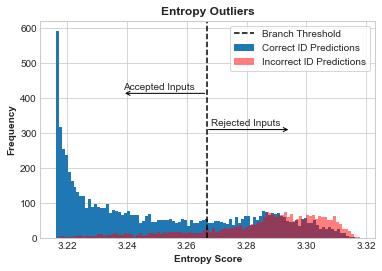

['exit_1']


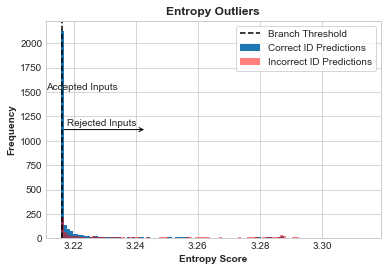

['exit_1', 'exit_2']


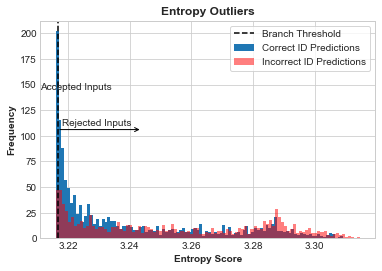

main_exit
   Exit_Name  ID_Inputs  Test_Accuracy Threshold  Accepted_Input  Accepted_Correct  Accepted_Accuracy  Rejected_Input  Accepted %
0     exit_1      10000         0.7144  3.266654            5466              4891           0.894804        0.453400    0.546600
1     exit_2       4534         0.8306  3.216428            2089              1931           0.924366        0.539259    0.460741
2  Main_exit       2445         0.8362        NA            2445              1429           0.584458        0.000000    1.000000


In [25]:

EvaluateID(output_ID,metrics=["entropy"], threshold="gmean", exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])

metric:  entropy threshold:  gmean


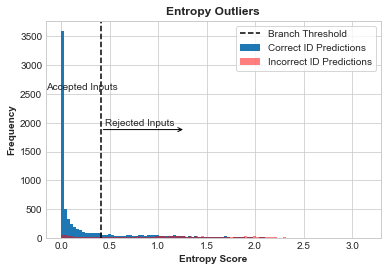

['exit_1']


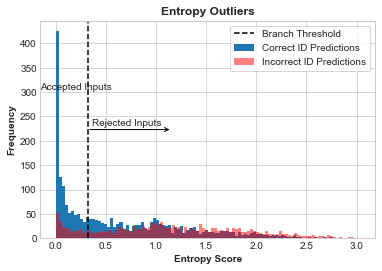

['exit_1', 'exit_2']


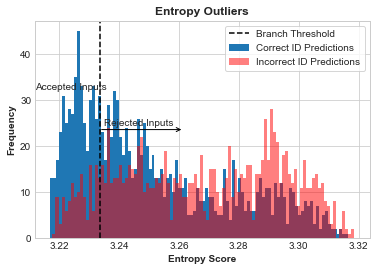

main_exit
   Exit_Name  ID_Inputs  Test_Accuracy Threshold  Accepted_Input  Accepted_Correct  Accepted_Accuracy  Rejected_Input  Accepted %
0     exit_1      10000         0.7839  0.414696            6168              5780           0.937095        0.383200    0.616800
1     exit_2       3832         0.8017   0.32181            1265              1033           0.816601        0.669885    0.330115
2  Main_exit       2567         0.8097        NA            2567              1368           0.532918        0.000000    1.000000


In [65]:
#SD sgd optimizer
EvaluateID(output_ID,metrics=["entropy"], threshold="gmean", exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])

In [83]:
def EvaluateOOD(ID,OOD,metrics=["energy"], threshold=None, exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
    '''
    Build an evaluation plot of the branched model's performance on ID and OOD datasets.

    ::Variables::
    ID: in-distribution dataset
    OOD: out of distribution dataset
    metrics: list of strings of metrics to evaluate branch results with. can be any of the following: ["gmean", "mean", "PR_AUC"]
    exit: #if a specific exit number is specified, only output the results of that exit. counts from 0 - N, with 0 being the main exit. -1 returns all exits
    legend: specify a legend to use for the plot
    main_exit_included: specify if the last exit must answer all inputs recieved, if False, it will use the threshold to accept and reject inputs
    plot: choose to produce a plot or just the table of branch results
    exit_labels: what labels to use for the exits, defaults to "exit_N" 
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    if type(metrics) is not list:
        metrics = [metrics]
    for j, metric in enumerate(metrics):
        print("metric: ", metric, "threshold: ",threshold)
        rollOver_ID_indices = pd.Index([])
        rollOver_OOD_indices = pd.Index([])
        Exit_Name=[]
        _ID = ID.copy()
        _OOD = OOD.copy()
        _ID.append(_ID.pop(0))
        _OOD.append(_OOD.pop(0))
        Accepted_df = pd.DataFrame()
        Input_ID=[]
        Input_OOD=[]
        Accepted_list =[]
        Accepted_ID_list = []
        Accepted_OOD_list = []
        Acceptance_correct =[]
        Input_predictions =[]
        Accepted_Ratio_list=[]
        Accepted_Accuracy_list=[]
        Branch_flops = []
        Thresholds=[]
        Test_accuracy =[]
        Rollover_accuracy=[]
        Results=[]
        
        if exit > 0: #if a specific exit number is specified, only output the results of that exit.
            _ID = [_ID[max(exit-1,0)]]
            _OOD = [_OOD[max(exit-1,0)]]
            exit_labels=['exit_{}'.format(exit)]
        for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
            Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                    print("threshold",_threshold)
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    Correct = output_ID.loc[(output_ID["correct"] == True)]
                    _threshold = np.array(Correct[metric]).mean()
                if _threshold == "gmean":
                    AUC_thresholds = evaluate.calc_AUC(output_ID, metrics=metric, plot = False)
                    _threshold = AUC_thresholds[j]
                if _threshold == "PR_AUC":
                    precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                    _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                else:
                    _threshold = np.float32(_threshold)

            if len(rollOver_ID_indices)>0:
                # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                output_ID = output_ID.iloc[rollOver_ID_indices]
            if len(rollOver_OOD_indices)>0:
                # if plot:
                # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                output_OOD = output_OOD.iloc[rollOver_OOD_indices]
            
            legend = ["Branch Threshold","Correct ID Predictions","Incorrect ID Predictions", "OOD Inputs"]
            Correct = output_ID.loc[(output_ID['correct'] == True)]
            Incorrect = output_ID.loc[(output_ID['correct'] == False)]
            if plot:
                
                _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram

            if plot:
                plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                plt.title(metric.capitalize() + " Outliers", weight="bold")
                # plt.legend(legend)
                plt.xlabel(metric.capitalize() + " Score", weight="bold")
                plt.ylabel("Frequency", weight="bold")
                plt.legend(legend,frameon=True)
                
                ## arrow annotation
                if lessThanMetrics:
                    ymax = plt.gca().get_ylim()
                    xmax = plt.gca().get_xlim()
                    ywidth = abs(ymax[0] - ymax[1])
                    xwidth = abs(xmax[0] - xmax[1])
                    print(ymax, ywidth)
                    print(xmax, _threshold- xmax[1]/10 )
                    
                    plt.text(max(_threshold- xwidth/4,xmax[0]) , (ywidth/1.5) + ywidth/60 ,"Accepted Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold - xwidth/4, ywidth/1.5), xytext=(_threshold, ywidth/1.5), arrowprops=dict(arrowstyle="->"))
                    
                    plt.text(min(_threshold + xwidth/80,xmax[1]), (ywidth/2)+ ywidth/60,"Rejected Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold + xwidth/4, ywidth/2), xytext=(_threshold, ywidth/2),  arrowprops=dict(arrowstyle="->"))
                else:
                    plt.annotate("", xy=(_threshold, 100), xytext=(_threshold, 0), arrowprops=dict(arrowstyle="->"))
                    
                plt.show()
            if main_exit_included and i == len(_ID)-1 :
                Exit_Name.append("Main_exit")
                _threshold
                if plot:
                    print("main_exit")
                OOD_accepted = output_OOD
                OOD_rejected = None
                ID_accepted = output_ID
                ID_rejected = None
                accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                rejected_correct = None
                accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                rejected_incorrect = None
                accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                _threshold = "NA"
            else:
                if metric in lessThanMetrics: ## metrics that require less than metric
                    OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                    OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                    ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                else: ### metrics that require greater than metric
                    OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                    OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                    ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                rollOver_ID_indices = ID_rejected.index
                rollOver_OOD_indices = OOD_rejected.index
                if i >= len(exit_labels):
                    exit_labels.append("exit_{}".format(i+1))
                print(exit_labels)
                Exit_Name.append(exit_labels[i])
            Thresholds.append(_threshold)
            
            Results.append(accepted_correct + accepted_incorrect)
            Input_ID.append(len(output_ID))
            Input_OOD.append(len(output_OOD))
            Accepted_ID_list.append(len(ID_accepted))
            Accepted_OOD_list.append(len(OOD_accepted))
            Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted) + len(OOD_accepted)))
            Acceptance_correct.append(len(accepted_correct))
            Accepted_Accuracy_list.append(overall_accepted_acc)
        df = pd.DataFrame({
        "Exit_Name":Exit_Name,
        "ID_Inputs":Input_ID,
        "OOD_Inputs":Input_OOD,
        "Test_Accuracy":Test_accuracy,
        # "RollOver_Accuracy":Rollover_accuracy,
        "Threshold":Thresholds,
        "Accepted ID":Accepted_ID_list,
        "Accepted OOD":Accepted_OOD_list,
            
        "Accepted_Correct":Acceptance_correct,
        "Accepted_ID_Ratio":Accepted_Ratio_list,
        "Acceptance_Accuracy":Accepted_Accuracy_list,

        # "Flops":Branch_flops,
        # "Cost Ratio":,                                  
                        })
        with pd.option_context('expand_frame_repr', False):
            print (df)

In [85]:
#branching adam e30
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=False,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.16685134312537958 Best Threshold=3.2160730361938477, G-Mean=0.7711443190136332, TPR=0.822594880847308, FPR=0.2770881820532713
['exit_1']
entropy  lr_auc 0.17047541609926065 Best Threshold=3.2160463333129883, G-Mean=0.7723711795611012, TPR=0.8288795124238162, FPR=0.28028473369772466
['exit_1', 'exit_2']
entropy  lr_auc 0.1571225761075942 Best Threshold=3.216141700744629, G-Mean=0.7817415708383205, TPR=0.812299219825608, FPR=0.24766653880577932
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7734  3.216073         5999          2325              5594           0.720687             0.672033
1     exit_2       4001        7675         0.7867  3.216046          759           680               611           0.527450             0.424600
2  Main_exit       3242        6995         0.7821        NA  

In [104]:
#bsd adam e30
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=False,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.15564405125907754 Best Threshold=0.2696065604686737, G-Mean=0.7702532326115975, TPR=0.7765237020316027, FPR=0.23596660244059087
['exit_1']
entropy  lr_auc 0.14498039366887178 Best Threshold=0.0002430278982501477, G-Mean=0.7833097004981604, TPR=0.8596321393998064, FPR=0.286236450718427
['exit_1', 'exit_2']
entropy  lr_auc 0.1386781875 Best Threshold=3.2230567932128906, G-Mean=0.7854740606792818, TPR=0.877, FPR=0.2965
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7785  0.269607         6444          2762              5948           0.699978             0.646100
1     exit_2       3556        7238         0.7934  0.000243          812           692               693           0.539894             0.460771
2  Main_exit       2744        6546         0.8000        NA         2744          6546  

In [44]:
#bsd sgd
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=False,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.17318279729614114 Best Threshold=0.10914711654186249, G-Mean=0.7515319669371723, TPR=0.7803315749811605, FPR=0.27620473727198475
['exit_1']
entropy  lr_auc 0.16327053581631 Best Threshold=0.007527342531830072, G-Mean=0.7662177616395967, TPR=0.8180347755762232, FPR=0.28231699216155176
['exit_1', 'exit_2']
entropy  lr_auc 0.15691596097201765 Best Threshold=3.225682258605957, G-Mean=0.7667589416946048, TPR=0.8232142857142857, FPR=0.2858247422680412
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7346  0.109147         5901          2649              5317           0.690175             0.621871
1     exit_2       4099        7351         0.7527  0.007527          967           993               763           0.493367             0.389286
2  Main_exit       3132        6358         0.7760        N

metric:  entropy threshold:  gmean
entropy  lr_auc 0.17867494721621519 Best Threshold=3.2164785861968994, G-Mean=0.7529828093370037, TPR=0.8002203452074917, FPR=0.29146626357015254


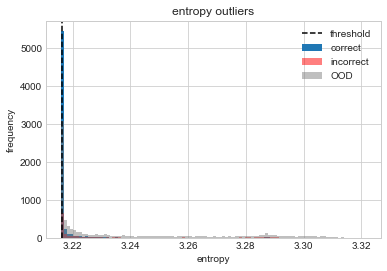

['exit_1']
entropy  lr_auc 0.18647754021451363 Best Threshold=3.216097116470337, G-Mean=0.752172080721501, TPR=0.7835390946502058, FPR=0.27793923381770147


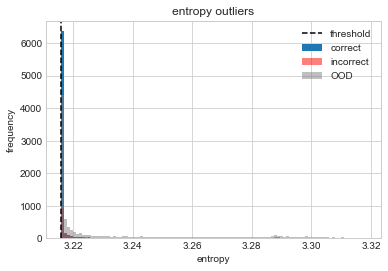

['exit_1', 'exit_2']
entropy  lr_auc 0.1682063804704375 Best Threshold=3.216196060180664, G-Mean=0.7619593619431579, TPR=0.8168604651162791, FPR=0.2892518440463646


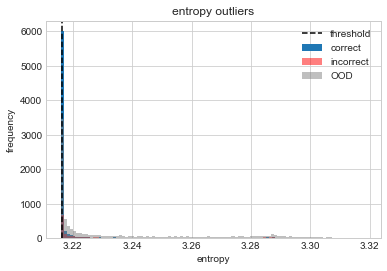

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7277  3.216479         5701          2589              5156           0.687696             0.621954
1     exit_2       4299        7411         0.7570  3.216097         1200          1253               946           0.489197             0.385650
2  Main_exit       3099        6158         0.7592        NA         3099          6158              1502           0.334774             0.162256


In [34]:
#branching adam
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.17914941648307342 Best Threshold=0.006383792031556368, G-Mean=0.7455942381633222, TPR=0.8025782688766114, FPR=0.30734385724090596


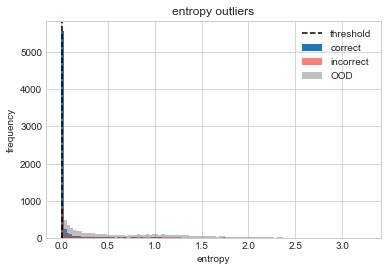

['exit_1']
entropy  lr_auc 0.19611794353428394 Best Threshold=0.001692609628662467, G-Mean=0.7315258083073503, TPR=0.7541785568691398, FPR=0.29044653504703855


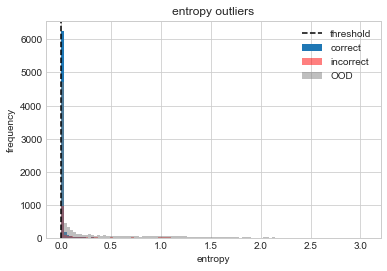

['exit_1', 'exit_2']
entropy  lr_auc 0.15914148618543164 Best Threshold=3.2193846702575684, G-Mean=0.771926895345272, TPR=0.8081734778982486, FPR=0.26269402788739804


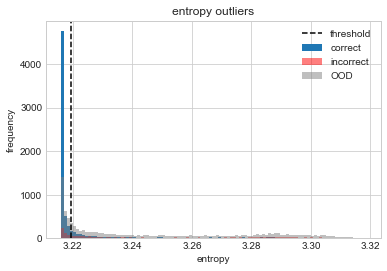

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7285  0.006384         5583          2380              5046           0.701118             0.633681
1     exit_2       4417        7620         0.7547  0.001693         1287          1544               973           0.454610             0.343695
2  Main_exit       3130        6076         0.7602        NA         3130          6076              1573           0.339996             0.170867


In [30]:
#bsd adam
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.19268015058912075 Best Threshold=3.2609822750091553, G-Mean=0.7365057907046717, TPR=0.7603550295857988, FPR=0.2865953947368421


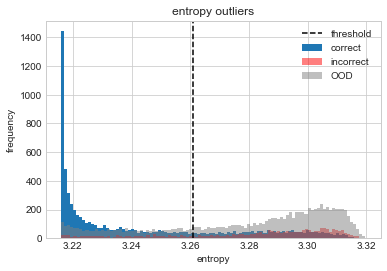

['exit_1']
entropy  lr_auc 0.1870035892005826 Best Threshold=3.2255501747131348, G-Mean=0.7458341461852601, TPR=0.7702508960573476, FPR=0.27780859916782247


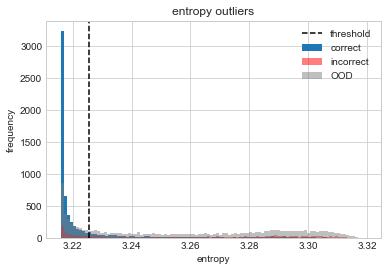

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7296  3.260982         5854          2684              5205           0.685641             0.609628
1  Main_exit       4146        7316         0.7210        NA         4146          7316              2060           0.361717             0.179724


In [60]:
#branchy adam
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.16942989792534446 Best Threshold=3.255749225616455, G-Mean=0.7563291480712097, TPR=0.8045930701047542, FPR=0.28903963820164935


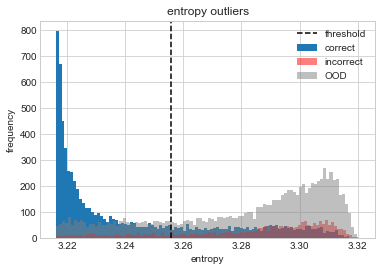

['exit_1']
entropy  lr_auc 0.22186869273505777 Best Threshold=1.270514726638794, G-Mean=0.7053121092531525, TPR=0.7946805060006488, FPR=0.3740060719965303


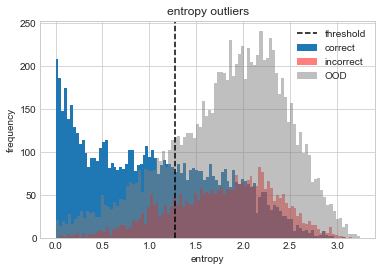

['exit_1', 'exit_2']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7518   3.255749         5831          2286              5345           0.718369             0.658495
1    exit_2       4169        7714         0.6917   1.270515          792           968               462           0.450000             0.262500


In [41]:
#BSD SGD_0.001
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=False,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.2226987774406568 Best Threshold=1.4505038261413574, G-Mean=0.7055884800175847, TPR=0.7488399071925754, FPR=0.33516483516483514


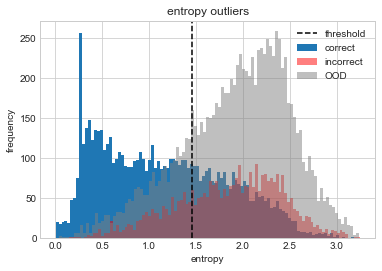

['exit_1']
entropy  lr_auc 0.17277704220056916 Best Threshold=3.2647457122802734, G-Mean=0.7575472593963388, TPR=0.7702808112324493, FPR=0.2549757934373319


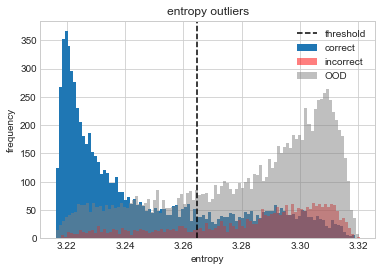

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6552  1.450504         5223          2127              4356           0.710612             0.592653
1  Main_exit       4777        7873         0.7436        NA         4777          7873              2890           0.377628             0.228458


In [49]:
#BSD adam_0.001
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.22186869273505777 Best Threshold=1.270514726638794, G-Mean=0.7053121092531525, TPR=0.7946805060006488, FPR=0.3740060719965303


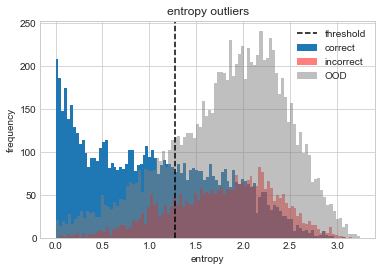

['exit_1']
entropy  lr_auc 0.16942989792534446 Best Threshold=3.255749225616455, G-Mean=0.7563291480712097, TPR=0.8045930701047542, FPR=0.28903963820164935


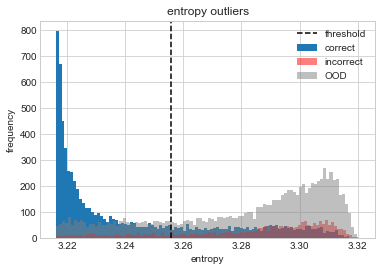

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6917  1.270515         4964          2004              4330           0.712400             0.621412
1  Main_exit       5036        7996         0.7518        NA         5036          7996              3082           0.386433             0.236495


In [42]:
#Baseline
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.1856927140476821 Best Threshold=3.267930746078491, G-Mean=0.7442406806629371, TPR=0.7676553672316384, FPR=0.27845982142857145


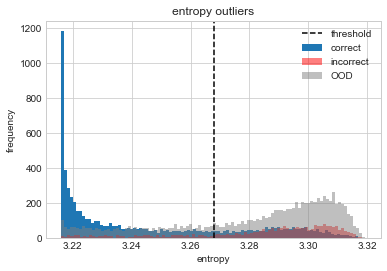

['exit_1']
entropy  lr_auc 0.1836042635315361 Best Threshold=3.223947525024414, G-Mean=0.745469835272858, TPR=0.7910284463894968, FPR=0.2974648663543676


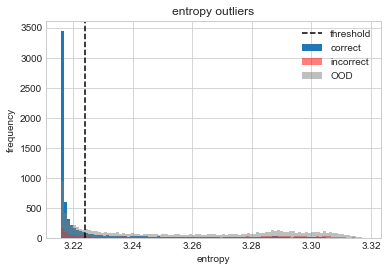

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7168  3.267931         5831          2967              5172           0.662764             0.587861
1  Main_exit       4169        7033         0.7258        NA         4169          7033              2193           0.372166             0.195769


In [48]:
#Branching
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.19417674560679388 Best Threshold=3.2819738388061523, G-Mean=0.7352470393732573, TPR=0.7308752584424535, FPR=0.2603550295857988


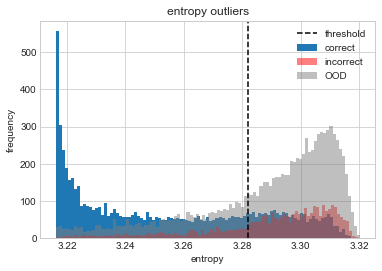

['exit_1']
entropy  lr_auc 0.18069844119215955 Best Threshold=3.2315311431884766, G-Mean=0.7490215787971545, TPR=0.7881387541961955, FPR=0.2881541194152207


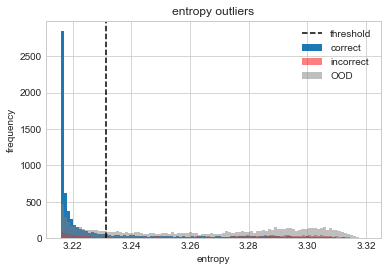

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7098  3.281974         6033          3065              5251           0.663113              0.57716
1  Main_exit       3967        6935         0.7319        NA         3967          6935              2120           0.363878              0.19446


In [43]:
#BSD
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.1341651753210079 Best Threshold=0.21491119265556335, G-Mean=0.7950990161256442, TPR=0.8664804469273742, FPR=0.27040194884287455


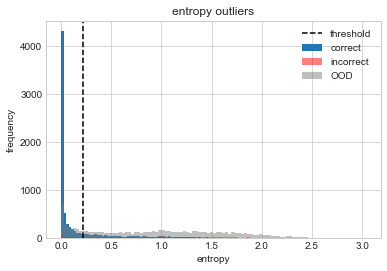

['exit_1']
entropy  lr_auc 0.12005006251371846 Best Threshold=0.02590709738433361, G-Mean=0.8114755626009562, TPR=0.8465473145780051, FPR=0.22214319582740635


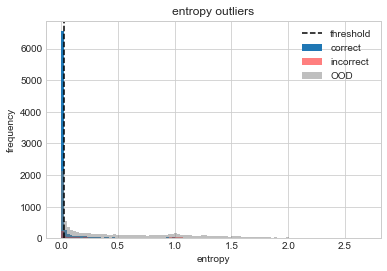

['exit_1', 'exit_2']
entropy  lr_auc 0.11912484109824943 Best Threshold=3.2332911491394043, G-Mean=0.8117346404128742, TPR=0.8481532147742818, FPR=0.2231201686577653


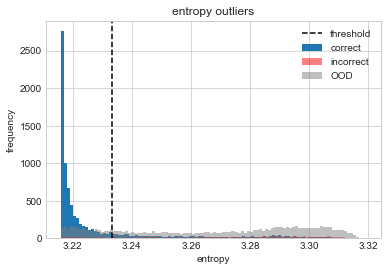

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.8210  0.214911         6230          1978              5990           0.759016             0.729776
1     exit_2       3770        8022         0.8436  0.025907         1211          1045              1063           0.536791             0.471188
2  Main_exit       2559        6977         0.8538        NA         2559          6977              1487           0.268352             0.155935


In [78]:
#BSD
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.19112388096335958 Best Threshold=3.2666544914245605, G-Mean=0.7396169014893824, TPR=0.7990196078431373, FPR=0.31536954087346025


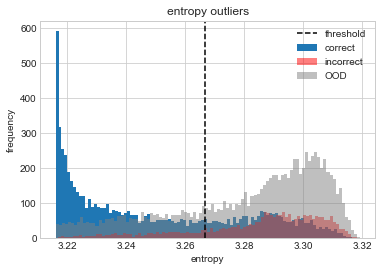

['exit_1']
entropy  lr_auc 0.1334109764324505 Best Threshold=3.216427803039551, G-Mean=0.7954076481384014, TPR=0.8541912632821723, FPR=0.2593306043823742


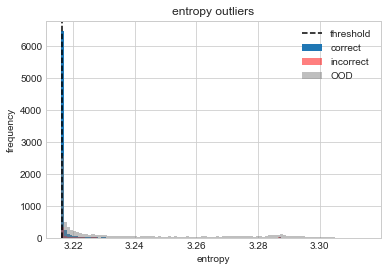

['exit_1', 'exit_2']
entropy  lr_auc 0.13560830596228823 Best Threshold=3.2167882919311523, G-Mean=0.793373837085172, TPR=0.8656898656898657, FPR=0.27290121980387466


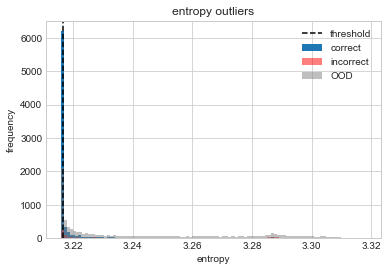

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7144  3.266654         5466          2814              4891           0.660145             0.590700
1     exit_2       4534        7186         0.8306  3.216428         2089          1216              1931           0.632073             0.584266
2  Main_exit       2445        5970         0.8362        NA         2445          5970              1429           0.290553             0.169816


In [69]:
#CE Early stopping, Calibration
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])
